In [239]:
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import pytz
from IPython.display import VimeoVideo
from pymongo import MongoClient
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import seaborn as sns

In [229]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    

    # Drop a  all column
    df = df.drop(columns=["unix",'symbol','low','open','high','Volume BTC','Volume USD'])


    # Convert date column to datetime format
    df["date"] = pd.to_datetime(df["date"])

    # Set date column as index
    df.set_index("date", inplace=True)

    #add lag featuer 
    df['close.L1']=df['close'].shift(1)

    # Drob NaN feature
    df.dropna(inplace=True)

    # Sort DataFrame by time series index
    df = df.sort_index(ascending=True)  
    
    
    
    return df

In [230]:
df=wrangle(r'C:\Users\Nassoh\Desktop\DataSienceMyProject\BTC Price\Data\BTCUSD_hour.csv')
df

,close,close.L1
date,,
2018-05-15 06:00:00,8740.99,8739.00
2018-05-15 07:00:00,8739.00,8728.49
2018-05-15 08:00:00,8728.49,8708.32
2018-05-15 09:00:00,8708.32,8795.90
2018-05-15 10:00:00,8795.90,8760.00
...,...,...
2023-04-24 19:00:00,27380.00,27453.00
2023-04-24 20:00:00,27453.00,27414.00
2023-04-24 21:00:00,27414.00,27468.00


In [231]:
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43338 entries, 2018-05-15 06:00:00 to 2023-04-24 23:00:00
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   close     43338 non-null  float64
 1   close.L1  43338 non-null  float64
dtypes: float64(2)
memory usage: 1015.7 KB


In [232]:
df.describe()

,close,close.L1
count,43338.000000,43338.000000
mean,21329.666615,21330.099446
std,16852.252461,16852.170017
min,3139.760000,3139.760000
25%,7797.467500,7797.467500
50%,13794.680000,13796.055000
75%,33942.032500,33942.032500
max,68627.010000,68627.010000


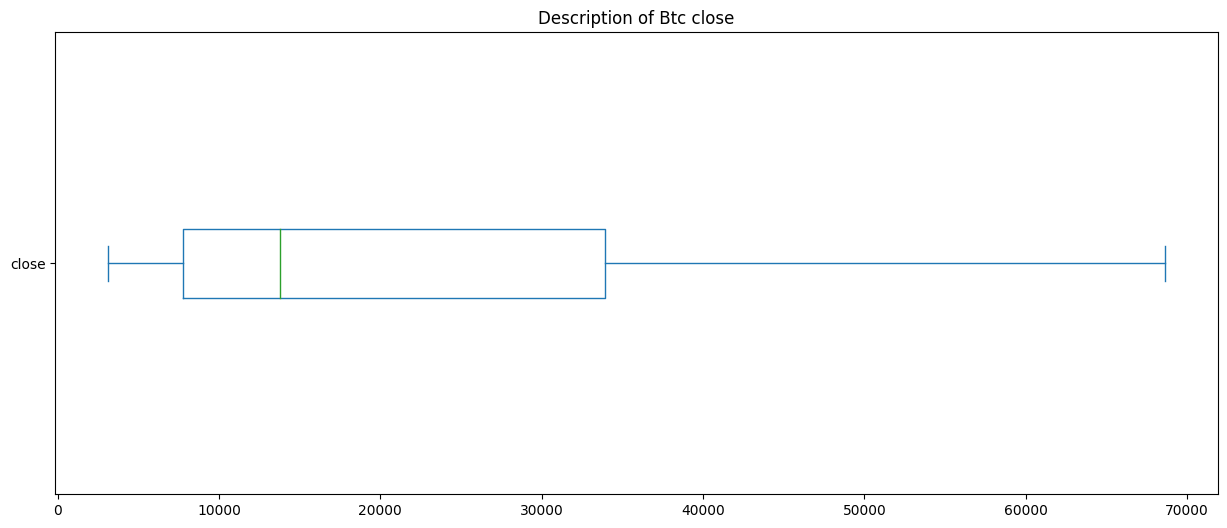

In [233]:
fig, ax = plt.subplots(figsize=(15, 6))
df['close'].plot(kind='box',vert=False,title='Description of Btc close',ax=ax)
plt.show()

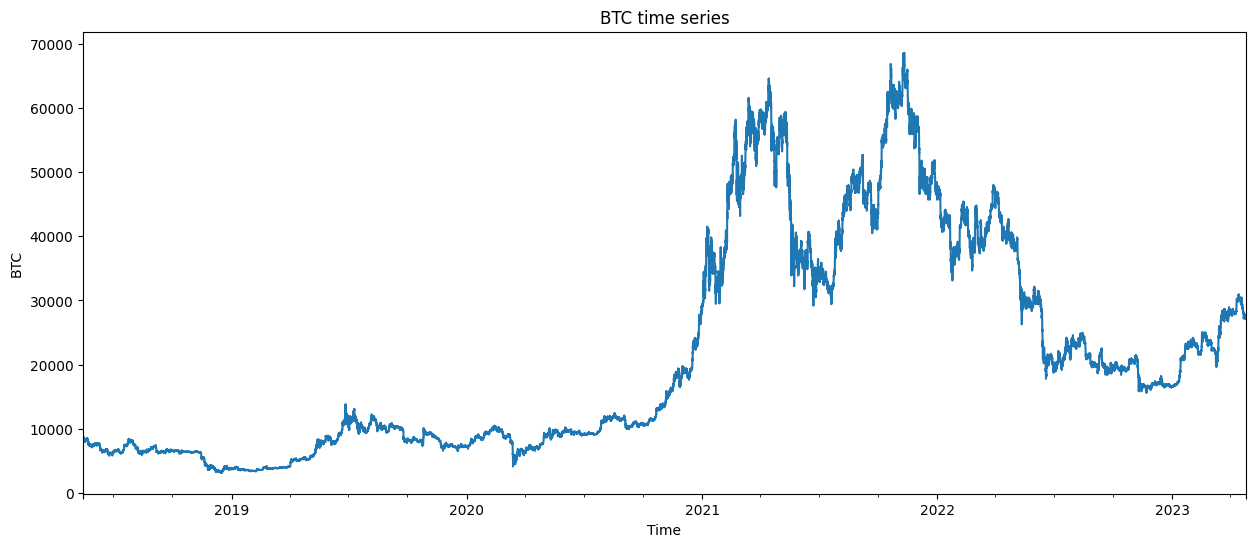

In [234]:
fig, ax = plt.subplots(figsize=(15, 6))
df['close'].plot(xlabel="Time",ylabel="BTC",title="BTC time series",ax=ax)
plt.show()


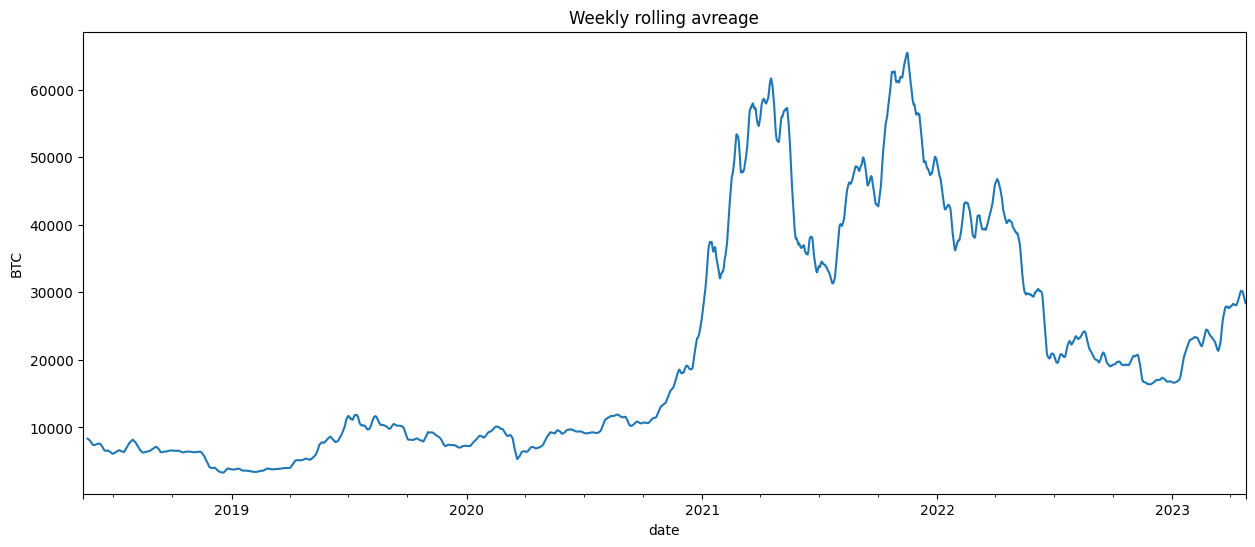

In [235]:
fig, ax = plt.subplots(figsize=(15, 6))
df["close"].rolling(168).mean().plot(ax=ax,ylabel='BTC',title='Weekly rolling avreage')
plt.show()

In [236]:
df.corr()

,close,close.L1
close,1.000000,0.999918
close.L1,0.999918,1.000000


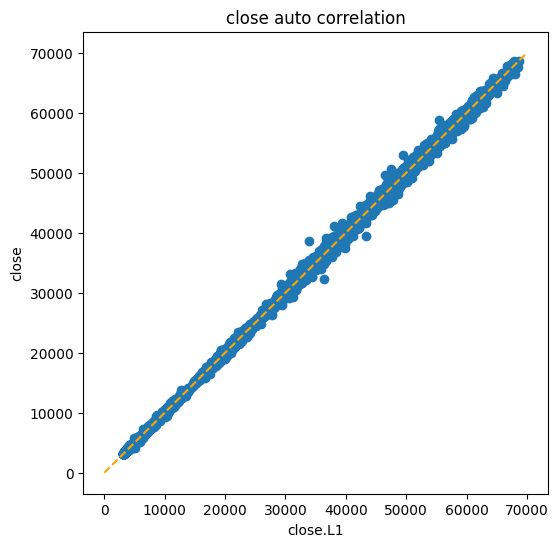

In [237]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x=df['close.L1'],y=df['close'])
ax.plot([0,70000],[0,70000],linestyle='--',color='orange')
plt.xlabel('close.L1')
plt.ylabel('close')
plt.title('close auto correlation')
plt.show()

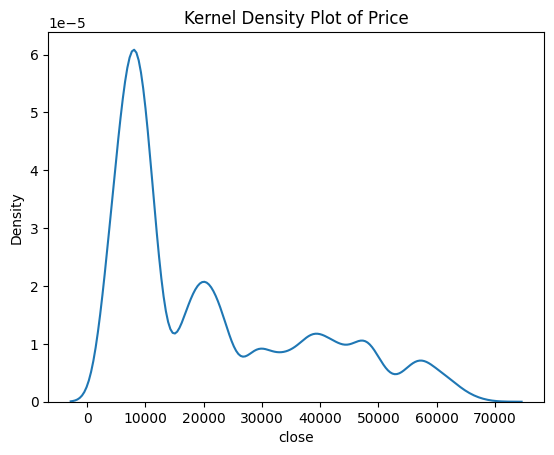

In [241]:
# Create a kernel density plot of the 'price' column
sns.kdeplot(df['close'])
plt.xlabel('close')
plt.ylabel('Density')
plt.title('Kernel Density Plot of Price')
plt.show()

# Spilte

In [242]:
target = "close"
y =df[target]
X =df.drop(columns=target)

In [243]:
cutoff =int(len(X)*0.8)

X_train, y_train =X.iloc[:cutoff],y.iloc[:cutoff]
X_test, y_test =X.iloc[cutoff:],y.iloc[cutoff:]


# Baseline

In [244]:
y_mean =y_train.mean()
y_pred_baseline =[y_mean]*len(y_train)
mae_baseline =mean_absolute_error(y_train,y_pred_baseline)

print("Mean close Reading:", round(y_train.mean(), 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean close Reading: 21006.89
Baseline MAE: 16736.99


## Build Model

In [245]:
model =LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

# Evaluate

In [246]:
training_mae =mean_absolute_error(y_train,model.predict(X_train))
test_mae =mean_absolute_error(y_test,model.predict(X_test))
print("Baseline MAE:", round(mae_baseline, 2))
print("Training MAE:", round(training_mae, 2))
print("Test MAE:", round(test_mae, 2))

Baseline MAE: 16736.99
Training MAE: 111.0
Test MAE: 89.65


# Intercept AND Coefficient For Model

In [247]:
intercept =model.intercept_.round(2)
coefficient =model.coef_.round(2)[0]

print(f"close = {intercept} + ({coefficient} * close.L1)")

close = 0.86 + (1.0 * close.L1)


In [248]:
df_pred_test =pd.DataFrame(
    {
        'X_test':X_test.values.flatten(),'y_test':y_test,'y_pred':model.predict(X_test)
    }
)
df_pred_test.head()

,X_test,y_test,y_pred
date,,,
2022-04-28 20:00:00,39843.07,39895.28,39840.594233
2022-04-28 21:00:00,39804.26,39843.07,39801.787483
2022-04-28 22:00:00,39754.20,39804.26,39751.731674
2022-04-28 23:00:00,39833.94,39754.20,39831.464997
2022-04-29 00:00:00,39831.15,39833.94,39828.675231


In [249]:
df_pred_test =pd.DataFrame(
    {
        'y_test':y_test,'y_pred':model.predict(X_test)
    }
)
df_pred_test.tail()

,y_test,y_pred
date,,
2023-04-24 19:00:00,27380.0,27451.561715
2023-04-24 20:00:00,27453.0,27412.564981
2023-04-24 21:00:00,27414.0,27466.560459
2023-04-24 22:00:00,27468.0,27510.556775
2023-04-24 23:00:00,27512.0,27497.557863


In [250]:
fig =px.line(df_pred_test,labels={'value':'close'})
fig.show()
